## Install the PGR-TK package

If neccessary, install the package into your python environment 
```
pip install --force /code/pgrtk-0.3.2-cp38-cp38-linux_x86_64.whl
```

In [1]:
import pgrtk
import os
import matplotlib.pyplot as plt
from IPython.display import SVG
%matplotlib inline

In [2]:
pgrtk.__version__

'pgrtk 0.3.2 (main:00d8eb3, release build, linux [x86_64] [rustc 1.62.0 (a8314ef7d 2022-06-27)])'

In [3]:
os.chdir("/results")

## Lazy load the the AGCfile for fetching sequences

In [4]:
ref_db =pgrtk.AGCFile("/data/pgr-tk-HGRP-y1-evaluation-set-v0.agc") # lazy load an agc file of the reference without any SHIMMER index 

## Load the index into memory
The loads the index into the memory. It takes about one minute.

In [5]:
%%time
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/data/pgr-tk-HGRP-y1-evaluation-set-v0")

CPU times: user 22.6 s, sys: 2min 33s, total: 2min 56s
Wall time: 2min 1s


We can see the specification about how SHIMMERs are computed using the `get_shmmr_spec()` method. 

In [6]:
sdb.get_shmmr_spec() # window_size, k_mer_size, hieraical_reduction_factor, min_span, use_k_mer_sketch_other_than_minimizer

(80, 56, 4, 64, False)

## Query the database with the sequence of the region

We use a copy of the annotation for IGV hg19 to look up the chromosome and locations of the gene of interest.
We can fetch the region of interest with `ref_db`. Let's fetch the whole region and do a dot plot to examine the repeat structure. 

42


(0.0, 65828.0)

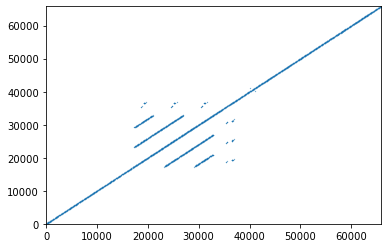

In [7]:
ref_file_name, roi_chr, roi_b, roi_e = 'hg19_tagged.fa', 'chr18_hg19', 44526786, 44628614-40000
padding = 2000
roi_len = roi_e - roi_b
#get a segment of a reference
roi_seq = ref_db.get_sub_seq(ref_file_name, roi_chr, roi_b-padding, roi_e+padding)
x, y = pgrtk.get_shmmr_dots(roi_seq, roi_seq, 32, 32, 2, 2)
plt.plot(x, y, ".", markersize=0.5)
print(x[0])
plt.xlim(0,len(roi_seq))
plt.ylim(0,len(roi_seq))

In [8]:
#find hits in the pangenomic reference
aln_range = pgrtk.query_sdb(sdb, roi_seq, merge_range_tol=100000)

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 138
The total aligned regions is 138


We can examine, the target region sizes.

In [9]:
rgn_lengths = []
for k in list(aln_range.keys()):
    b, e = aln_range[k][0][0:2]
    print(sdb.seq_info[k], "target region", b, "-", e, "len:", e-b )
    rgn_lengths.append(e-b)

('HG02559#2#JAGYVJ010000315.1', 'HG02559.maternal.f1_assembly_v2_genbank.fa', 68474) target region 1185 - 68000 len: 66815
('HG02486#2#JAGYVL010000227.1', 'HG02486.maternal.f1_assembly_v2_genbank.fa', 24449) target region 324 - 24190 len: 23866
('HG01175#1#JAHAMA010000064.1', 'HG01175.paternal.f1_assembly_v2_genbank.fa', 34803293) target region 17344595 - 17445691 len: 101096
('HG02630#1#JAHAOQ010000064.1', 'HG02630.paternal.f1_assembly_v2_genbank.fa', 40936662) target region 18872127 - 19038347 len: 166220
('NA20129#2#JAHEPD010000098.1', 'NA20129.maternal.f1_assembly_v2_genbank.fa', 22764029) target region 14926736 - 15027799 len: 101063
('HG00735#2#JAHBCG010000036.1', 'HG00735.maternal.f1_assembly_v2_genbank.fa', 33355484) target region 33300726 - 33353419 len: 52693
('HG02622#1#JAHAOO010000039.1', 'HG02622.paternal.f1_assembly_v2_genbank.fa', 55384504) target region 33285382 - 33480896 len: 195514
('HG01978#1#JAGYVS010000046.1', 'HG01978.paternal.f1_assembly_v2_genbank.fa', 35992166

Text(0, 0.5, 'count')

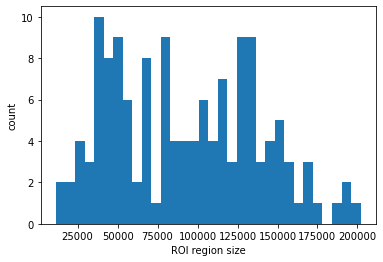

In [10]:
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI region size")
plt.ylabel("count")

Some mapped regions are larger, let's check the repeat / CNV by quick dot plots. We label the region of the ROI by two vertical grey lines. We observe that there are different number of intersections (~different copy number of the ROI) of the region the "dots" due to the different repeat structures.

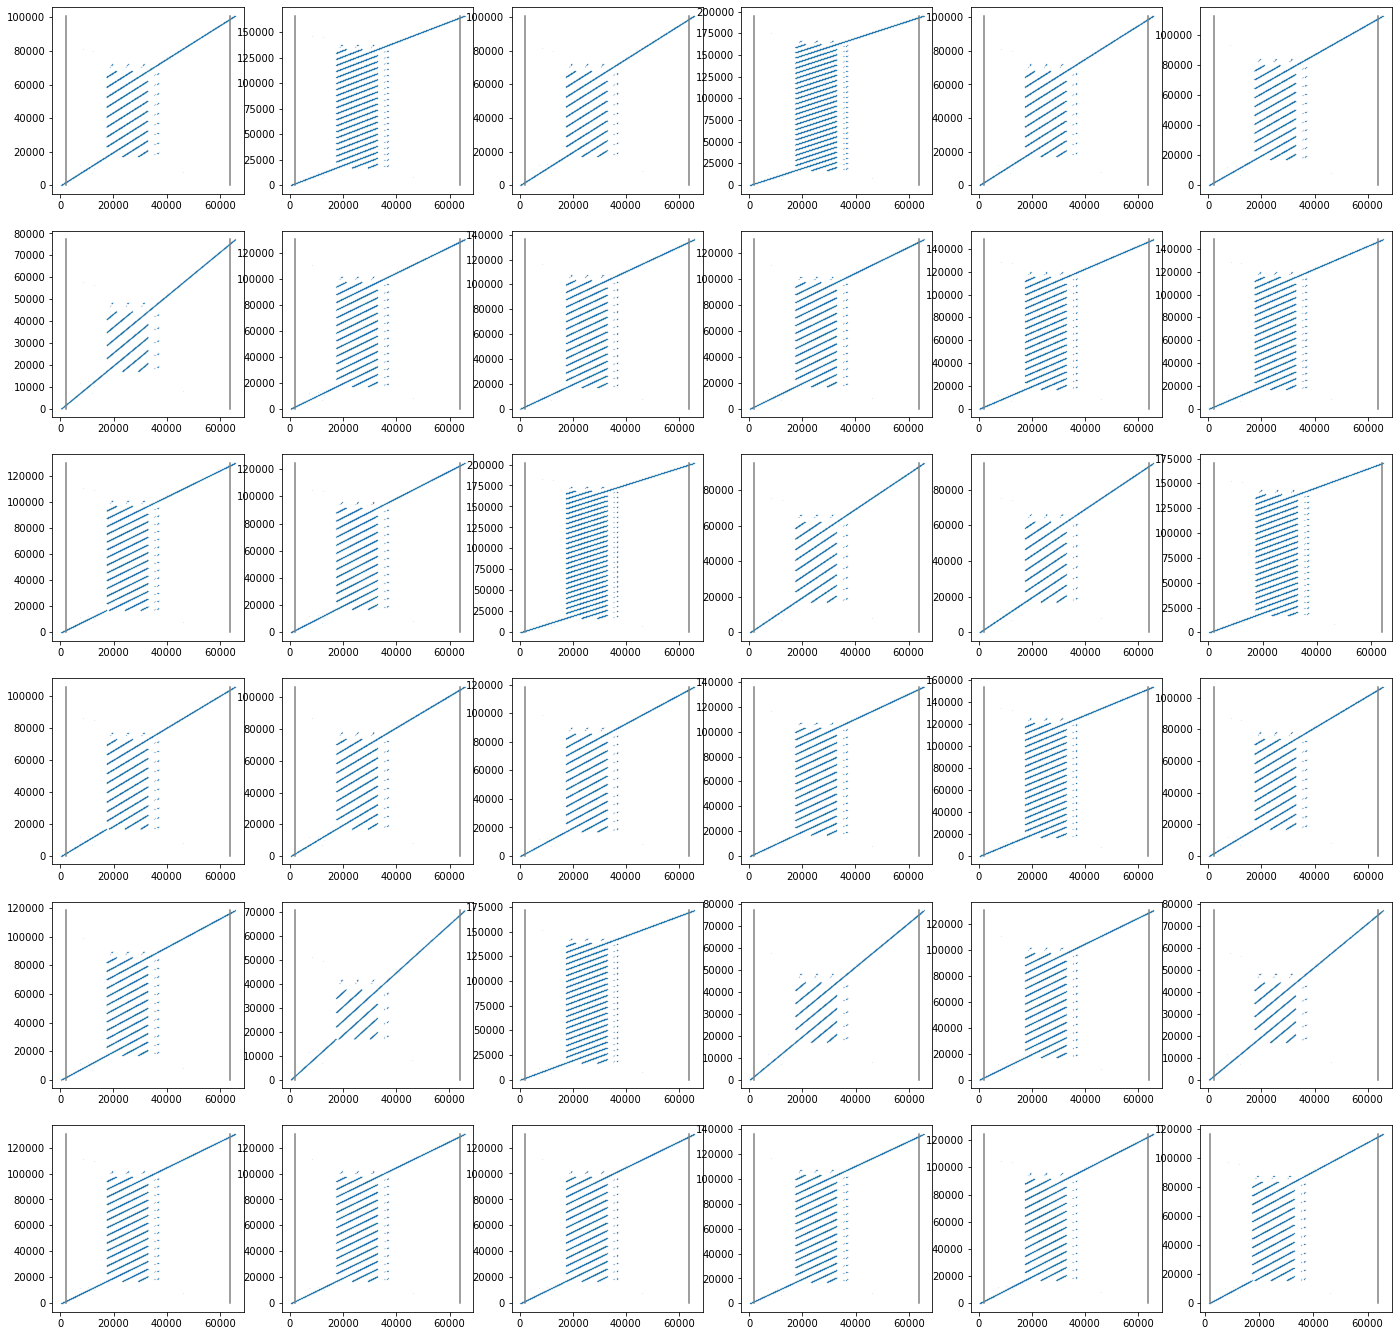

In [11]:
seq_list = []
i = 1
plt.figure(figsize=(24, 24))
for k in list(aln_range.keys()):
    ctg_name, source, _ = sdb.seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()

    rgns = pgrtk.merge_regions(rgns, tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        aln.sort()
  
        if aln[0][0][0] > padding or aln[-1][0][1] < padding + roi_len:
            continue
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        #if e-b < 0.75 * (roi_len + 2 * padding):             
        #    continue

        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
  
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)

        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        x, y = pgrtk.get_shmmr_dots(roi_seq, seq, 32, 32, 1, 1)
        
        
        if i <= 36:
            plt.subplot(6,6,i)
            plt.plot(x, y, ".", markersize=0.1)
            plt.plot([padding, padding],[0, max(y)], color='grey')
            plt.plot([padding+roi_len, padding+roi_len],[0, max(y)], color='grey')
        i += 1
        
        
        
        

## Create a new shimmer database for the detailed study

In [12]:
seq_list = []
seq_info = sdb.seq_info.copy()
i = 0
for k in list(aln_range.keys()):
    ctg_name, source, _ = seq_info[k]
    seq_id = k
    rgns = aln_range[k].copy()
    
    rgns = pgrtk.merge_regions(rgns,tol=1000)

    for rgn in rgns:
        b, e, length, orientation, aln = rgn
        
        #for illustration purpose, we only plot with the sequnce spanned through the whole region

        if e-b < 0.75 * (roi_len + 2 * padding):             
            continue
            
        seq =  sdb.get_sub_seq(source, ctg_name, b, e)
        if orientation == 1:
            seq = pgrtk.rc_byte_seq(seq)
  
        seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
        
        i += 1



Create a shimmer indext database with smaller window (denser shimmers)

In [13]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)

In [14]:
len(new_sdb.seq_info)

107

In [15]:
#find hits in the pangenomic reference
aln_range0 = pgrtk.query_sdb(new_sdb, roi_seq, merge_range_tol=300000)

aln_range = aln_range0

print("The number of hits is", len(aln_range))

count = 0
for sid, rgns in aln_range.items():
    count += len(rgns)

print("The total aligned regions is", count)

The number of hits is 107
The total aligned regions is 107


Let's loop through the hits (contigs that has alignments) and see the number of "copies".

In [16]:
from collections import Counter

In [17]:
n_copy = {}
for k in list(aln_range.keys()):
    n_copy[k] = len(aln_range[k])
copy_count = Counter(n_copy.values())
for nc, nh in copy_count.items():
    print("number of copy: {}, number of haplotypes: {}".format(nc, nh))

number of copy: 1, number of haplotypes: 107


Text(0, 0.5, 'count')

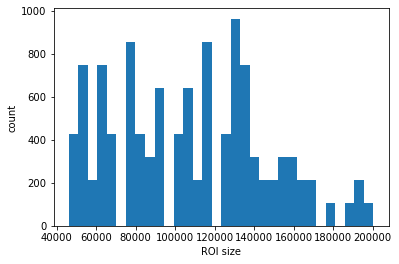

In [18]:
rgn_lengths = []
for k in list(aln_range.keys()):
    for sid, rgns in aln_range.items():
        for rgn in rgns:
            b, e = rgn[0:2]
            #print(seq_index[k], "target region", b, "-", e, "len:", e-b )
            rgn_lengths.append(e-b)
plt.hist(rgn_lengths, bins=32);
plt.xlabel("ROI size")
plt.ylabel("count")

In [19]:
f0 = open("/results/AMY1A_region_seq.fa", "w")
for ctg, seq in seq_list:
    
    print(">{}".format(ctg), file=f0)
    print(pgrtk.u8_to_string(seq), file=f0)
       
f0.close()

In [20]:
help(new_sdb.generate_mapg_gfa)

Help on built-in function generate_mapg_gfa:

generate_mapg_gfa(...) method of builtins.SeqIndexDB instance
    Convert the adjecent list of the shimmer graph shimmer_pair -> GFA
    
    Parameters
    ----------
    min_count : int
        the minimum number of times a pair of shimmers must be observed to be included in the graph
    
    filenpath : string
        the path to the output file
    
    Returns
    -------
    
    None
        The data is written into the file at filepath



In [21]:
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=6, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_6.gfa")

new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, w=80, k=56, r=2, min_span=18)
new_sdb.generate_mapg_gfa(0, "/results/ROI_80_56_2.gfa")

## Construct the genome graphs

In [22]:
import networkx as nx
from networkx.drawing import nx_pydot 

In [23]:
def get_graph(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  2 + 0.1 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    node_to_sid = {}
    for v in G.nodes():
        node_to_sid.setdefault(v, {})
        for sid, path in sid_to_path.items():
            node_to_sid[v][sid] = 0
            
     
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        for v in path:
            v = tuple(v[-2:])
            node_to_sid[v][sid] = 1
    #nx.set_node_attributes(G, node_to_sid)  
    return G
    

In [24]:
def get_graph2(seq_list, w=128, k=56, r=4, min_span=28, highlite=0):
    new_sdb = pgrtk.SeqIndexDB() 
    new_sdb.load_from_seq_list(seq_list, w=w, k=k, r=r, min_span=min_span)
    new_sdb.generate_mapg_gfa(0, f"/results/{name}-{w}-{k}-{r}.gfa")
    sid_to_path = {}
    spl=new_sdb.get_shmmr_pair_list()
    for (k0, k1, sid, p0, p1, o) in spl:
        sid_to_path.setdefault(sid,[])
        sid_to_path[sid].append((p0, p1, o, k0, k1))
    G = nx.DiGraph()
    m = new_sdb.get_shmmr_map()
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        #if sid != 45:
        #    continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "yellow"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_edge(v, w, penwidth = penwidth, color="orange" )
            G.add_edge(w, v, penwidth = penwidth, color="orange" )
            G.add_node(v, fillcolor=color, style="filled")
            #G.add_node(w, size =  len(m[v]))
            v = w
            
    for sid, path in sid_to_path.items():
        #print(sid)
        path.sort()
        v = path[0]
        if sid != highlite:
            continue
        for w in path[1:]:
            v = tuple(v[-2:])
            w = tuple(w[-2:])
            color = "blue"
            penwidth =  1 + 0.02 * (len(m[v]) * len(m[w])) ** 0.5
            G.add_node(v, fillcolor=color, style="filled")
            G.add_edge(v, w, penwidth = penwidth, color=color )
            G.add_edge(w, v, penwidth = penwidth, color=color )
            v = w
    return G
    

## Generate Repeat Pattern Using the Principal Bundles

In [25]:
shmmrspec = {"w": 64, "k":56, "r":1, "min_span":28 }
new_sdb = pgrtk.SeqIndexDB() 
new_sdb.load_from_seq_list(seq_list, 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])

In [26]:
principal_bundles, sid_smps = new_sdb.get_principal_bundle_decomposition(0,8)
sid_smps = dict(sid_smps)
print(len(principal_bundles))

26


In [27]:
import numpy as np
from matplotlib import cm

In [28]:
cmap=plt.get_cmap("nipy_spectral")
cmap

In [29]:
lpb = len(principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

[ 0  3  6  9 12 15 18 21 24  1  4  7 10 13 16 19 22 25  2  5  8 11 14 17
 20 23]


In [30]:
new_sdb.generate_mapg_gfa(0, "/results/test_48_56_4_28.gfa")

v_to_name = {}
with open("/results/test_48_56_4_28.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/test_48_56_4_28_color.csv", "w")
print("Name,Color", file=f)
for bundle_id, bundle in enumerate(principal_bundles):
    for v in bundle[2]:
        vertex = tuple(v[:2])
        color = color_theme[bundle_id]
  
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

In [31]:
b_vertex_to_position = {}
i = 0
for bundle in principal_bundles:
    for v in bundle[2]:
        vertex = tuple(v[:2])
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1

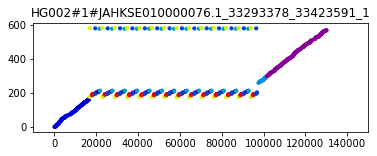

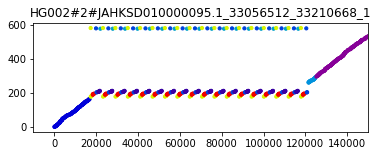

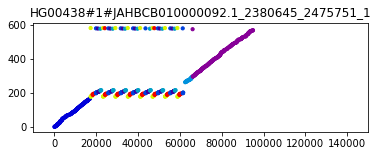

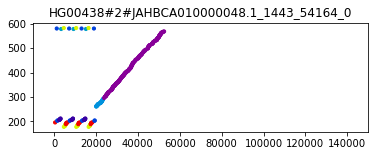

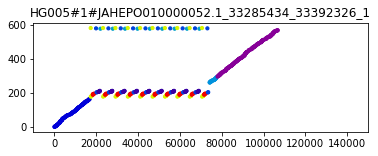

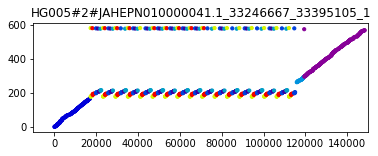

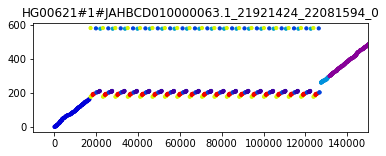

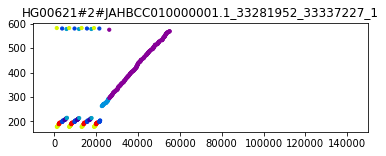

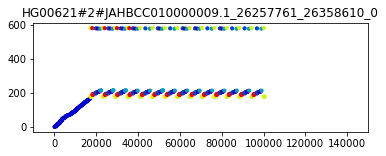

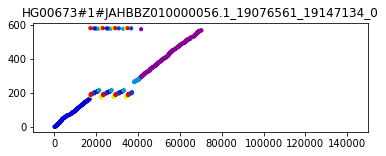

In [32]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

#fig = plt.figure(figsize=(24,96))
pidx = 1
for sid, data in sinfo[:10]:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        vertex = tuple(s[0][:2])
        x.append(s[0][2])
        y.append(b_vertex_to_position[vertex][0]) # same direction
        c.append(color_theme[s[1][0]])
            

    fig = plt.figure(figsize=(6,2))
    plt.scatter(x, y, marker=".", color=c, s=40)
    
    
    plt.xlim(-10000,150000)
    plt.title(ctg)
    

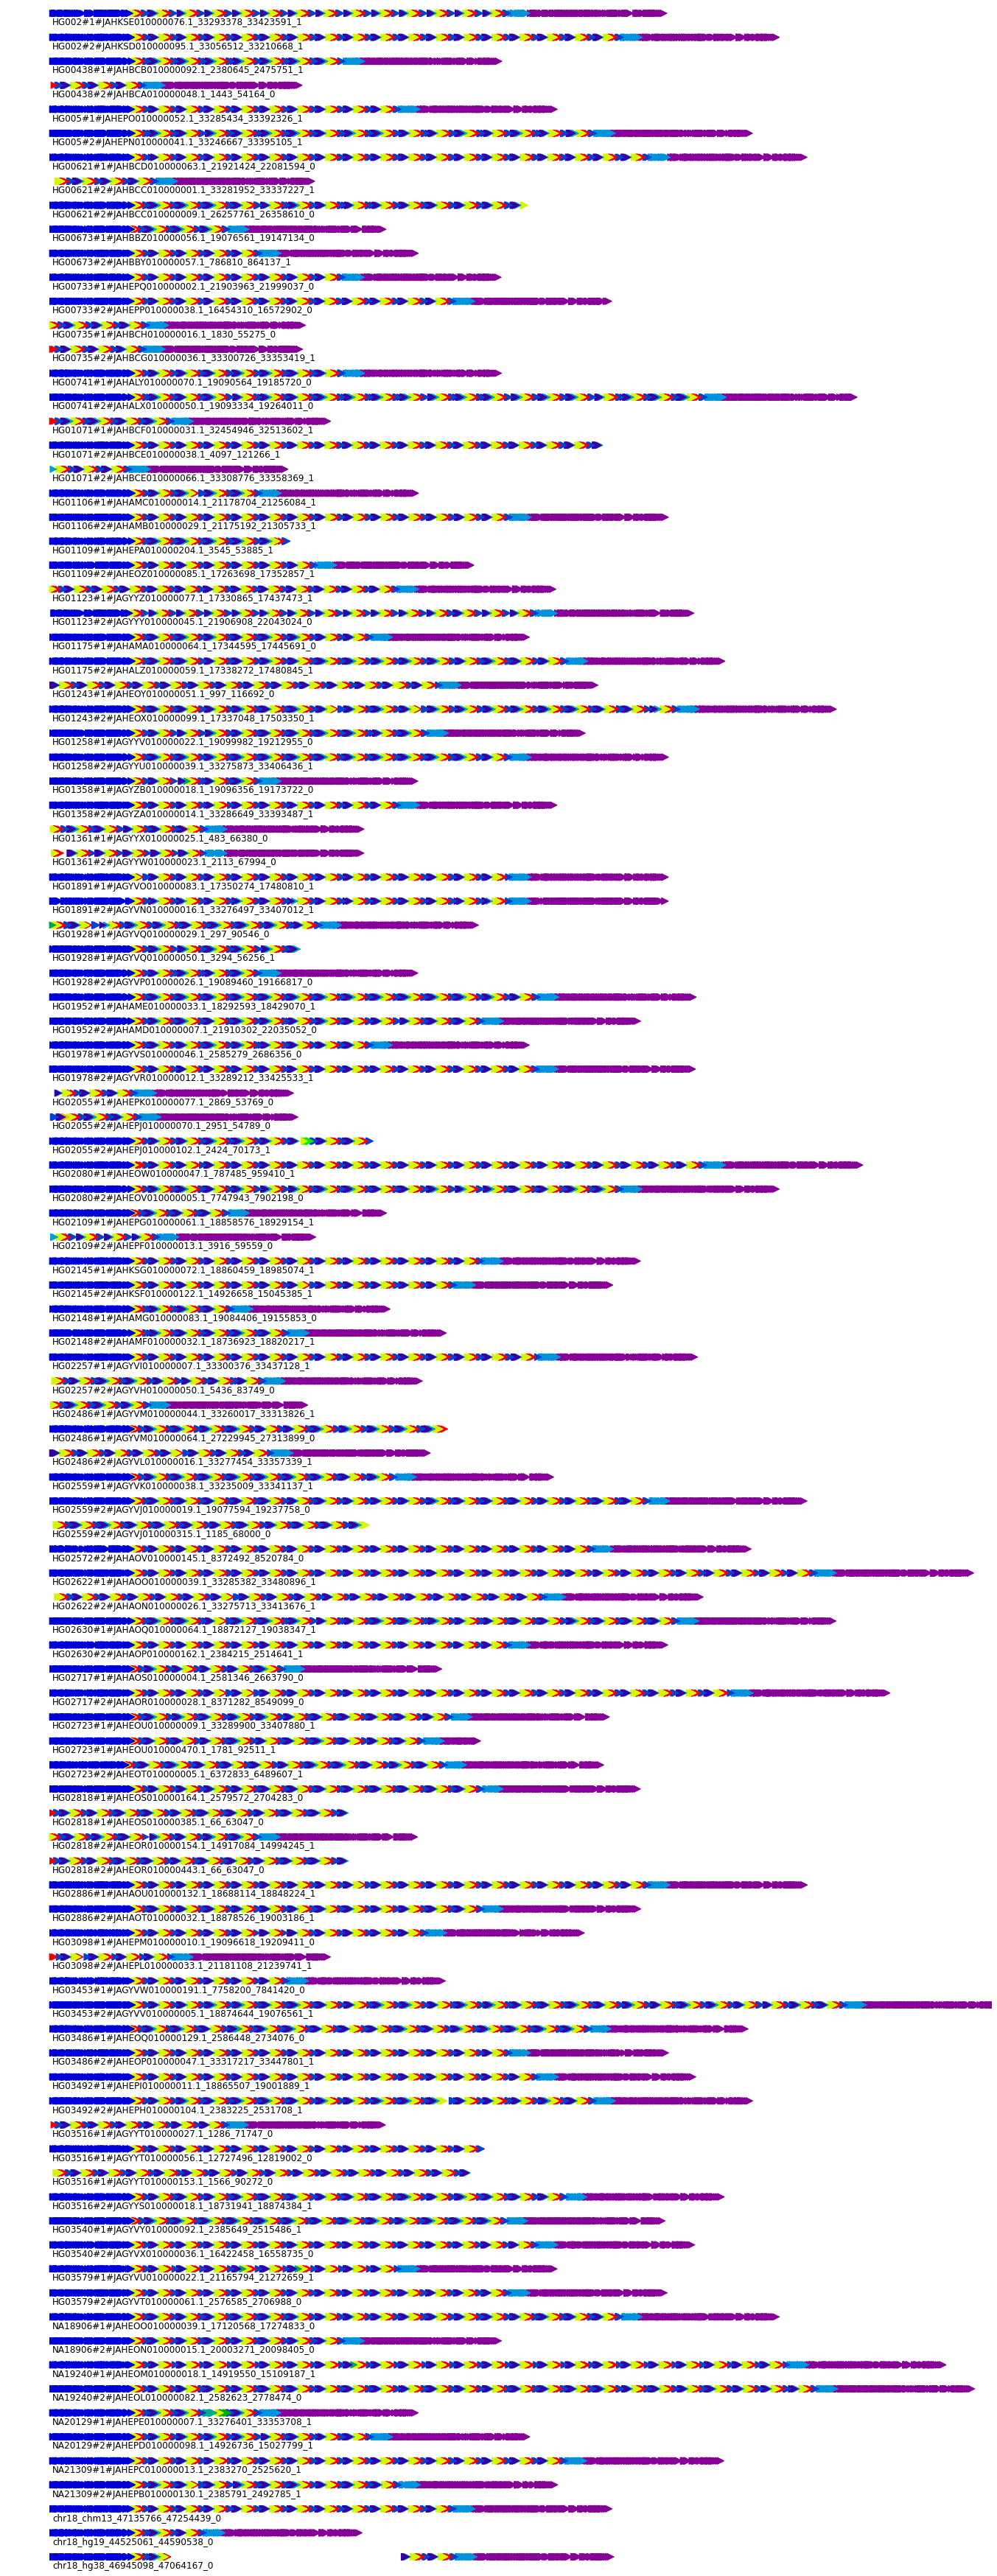

In [33]:
seq_info = new_sdb.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,64))
pidx = 1
for sid, data in sinfo:
    ctg, _, _ = data
    smps = sid_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    track0_x = []
    track0_c = []
   
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])
        # if tuple(s[0][2:4]) in matches:
        #     track0_x.append(s[0][2])
        #     track0_c.append(fcolors[s[1][0]])
            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(len(sid_smps), 1, pidx)

    pidx += 1
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    
    plt.axis("off")
    plt.ylim(-14,10)
    plt.xlim(-10000,200000)
    plt.text(0, -14, ctg, fontsize=12)

## Repeat analsysis 

In [34]:
bundle_id_count = []
for sid, data in sinfo:
    smps = sid_smps[sid]
    for s in smps:
        if s[1] is not None:
            bundle_id_count.append(s[1][0])
    
bundle_id_count = Counter(bundle_id_count)

In [35]:
principal_bundles_length = dict([ (_[0], len(_[2])) for _  in principal_bundles ])

In [37]:
repeat_bundles = set()
for bid, count in bundle_id_count.items():
    if count/principal_bundles_length[bid] > 96 * 3:
        print(bid, count/principal_bundles_length[bid])
        repeat_bundles.add(bid)

6 999.3636363636364
8 944.0
10 789.625
9 983.25
11 579.25


In [38]:
repeat_bundles

{6, 8, 9, 10, 11}

In [39]:
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])
bundle_id_count = []
bundle_list = {}

# count most repeative bundle in a sequence
for seq_id, data in sinfo:

    smps = sid_smps[sid]

    bundle_list.setdefault(seq_id, [])
  
    for s in smps:
        if s[1] is None:
            continue
  
        smp = s[0]
        node = smp[0], smp[1]
        direction = smp[4]
        bundle_id = s[1][0]
        
        if bundle_id not in repeat_bundles:
            continue
  
        bundle_list[seq_id].append( bundle_id )

In [40]:
c = []
for seq_id, data in sinfo:
    c.extend(bundle_list[seq_id])
Counter(c).most_common(20)

[(6, 4066), (8, 2568), (9, 1926), (10, 1177), (11, 642)]

In [41]:
### Fetch the repeat by breaking at the first shimmer pair of pincipal bundle 7 as it is more common element

In [42]:
repeat_start = {}
flag = 0
key_node = None
for seq_id, data in sinfo:
    ctg, src, _ = data
    #print(ctg, src)
    seq=new_sdb.get_seq_by_id(seq_id)
    smps = pgrtk.get_shmmr_pairs_from_seq(seq,  
                                          w = shmmrspec["w"], 
                                          k = shmmrspec["k"], 
                                          r = shmmrspec["r"],
                                          min_span = shmmrspec["min_span"])
    repeat_start.setdefault(seq_id, [])
    bundle_list.setdefault(seq_id, [])
    x = []
    
    for smp in smps:
        node = smp[0], smp[1]
        direction = smp[4]
        if node in b_vertex_to_position:
            if b_vertex_to_position[node][1] == 6:
                if flag == 0:
                    key_node = node
                    flag = 1
            else:
                flag = 0
                
            if key_node is not None and node == key_node:
                repeat_start[seq_id].append(smp[2])



In [45]:
f = open("/results/KATNAL2_repeat_units.fa", "w")
f2 = open("/results/KATNAL2_repeat_tail_units.fa", "w")

for seq_id, data in sinfo:
    ctg, src, _ = data

    rs = repeat_start[seq_id]
   
    for i in range(len(rs)-1):
        b, e = rs[i], rs[i+1]
        seq = new_sdb.get_seq_by_id(seq_id)
        seq = pgrtk.u8_to_string(seq[b:e])
        print(f">{ctg}:{b}_{e}", file=f)
        print(f"{seq}", file=f)
        if len(seq) < 5200 or len(seq) > 6500:
            print(f">{ctg}:{b}_{e}", len(seq))
    
    b = rs[-1]
    e = b + 25000
    seq = new_sdb.get_seq_by_id(seq_id)
    seq = pgrtk.u8_to_string(seq[b:e])
    print(f">{ctg}:{b}_{e}", file=f2)
    print(f"{seq}", file=f2)
f.close()
f2.close()
        

>HG01243#1#JAHEOY010000051.1_997_116692_0:67280_73998 6718
>HG02257#1#JAGYVI010000007.1_33300376_33437128_1:88391_95110 6719
>chr18_hg38_46945098_47064167_0:23294_76886 53592


## Analyzing the repeat units with PCA

In [122]:
shmmrspec = {"w": 56, "k":56, "r":1, "min_span":0 }
repeat_db = pgrtk.SeqIndexDB() 
repeat_db.load_from_fastx("/results/KATNAL2_repeat_units.fa", 
                           w = shmmrspec["w"], 
                           k = shmmrspec["k"], 
                           r = shmmrspec["r"], 
                           min_span = shmmrspec["min_span"])



In [123]:
repeat_principal_bundles, repeat_sid_to_smps = repeat_db.get_principal_bundle_decomposition(0, 24);
repeat_sid_to_smps = dict(repeat_sid_to_smps)

get the vertex to bundle id map

In [124]:
vertex_to_bundle_id = {}
x = 0
bundle_id = 0
for bundle_id, order, bundle in repeat_principal_bundles:
    for v in bundle:
        vertex_to_bundle_id[tuple(v[:2])] = bundle_id, v[2]

### Generate A GFA file of the repeat graph with pricinple bundle color annotation

In [125]:
from matplotlib.colors import to_hex as to_hex

In [126]:
repeat_db.generate_mapg_gfa(0, "/results/KATNAL2_repeats.gfa")

v_to_name = {}
with open("/results/KATNAL2_repeats.gfa") as f:
    for r in f:
        r = r.strip().split("\t")
        if r[0] != "S":
            continue
        n = r[1]
        v = r[4].split(":")[-1]
        v_to_name[v] = n

f = open("/results/KATNAL2_repeats_color.csv", "w")

lpb = len(repeat_principal_bundles)
color_theme0 = cmap(np.linspace(0.1, 0.9, lpb))
#pseudo-randomize the colors
idx = np.array([_ * (lpb+8011) for _ in range(lpb)]) % lpb
print(idx)
color_theme = color_theme0[idx]

print("Name,Color", file=f)
for bundle_id, _, bundle in repeat_principal_bundles:
    for v in bundle:
        vertex = tuple(v[:2])
        bundle_id = vertex_to_bundle_id[tuple(v[:2])][0]
        color = to_hex(color_theme[bundle_id])
        #color = color.to_hex()
        print(v_to_name["{:016x}_{:016x}".format(*vertex)], color, file=f, sep=",")
f.close()

[0 1 2 3 4 5]


In [127]:
#gene_matches1 = repeat_db.get_match_positions_with_fragment(roi1_seq)
gene_matches = []

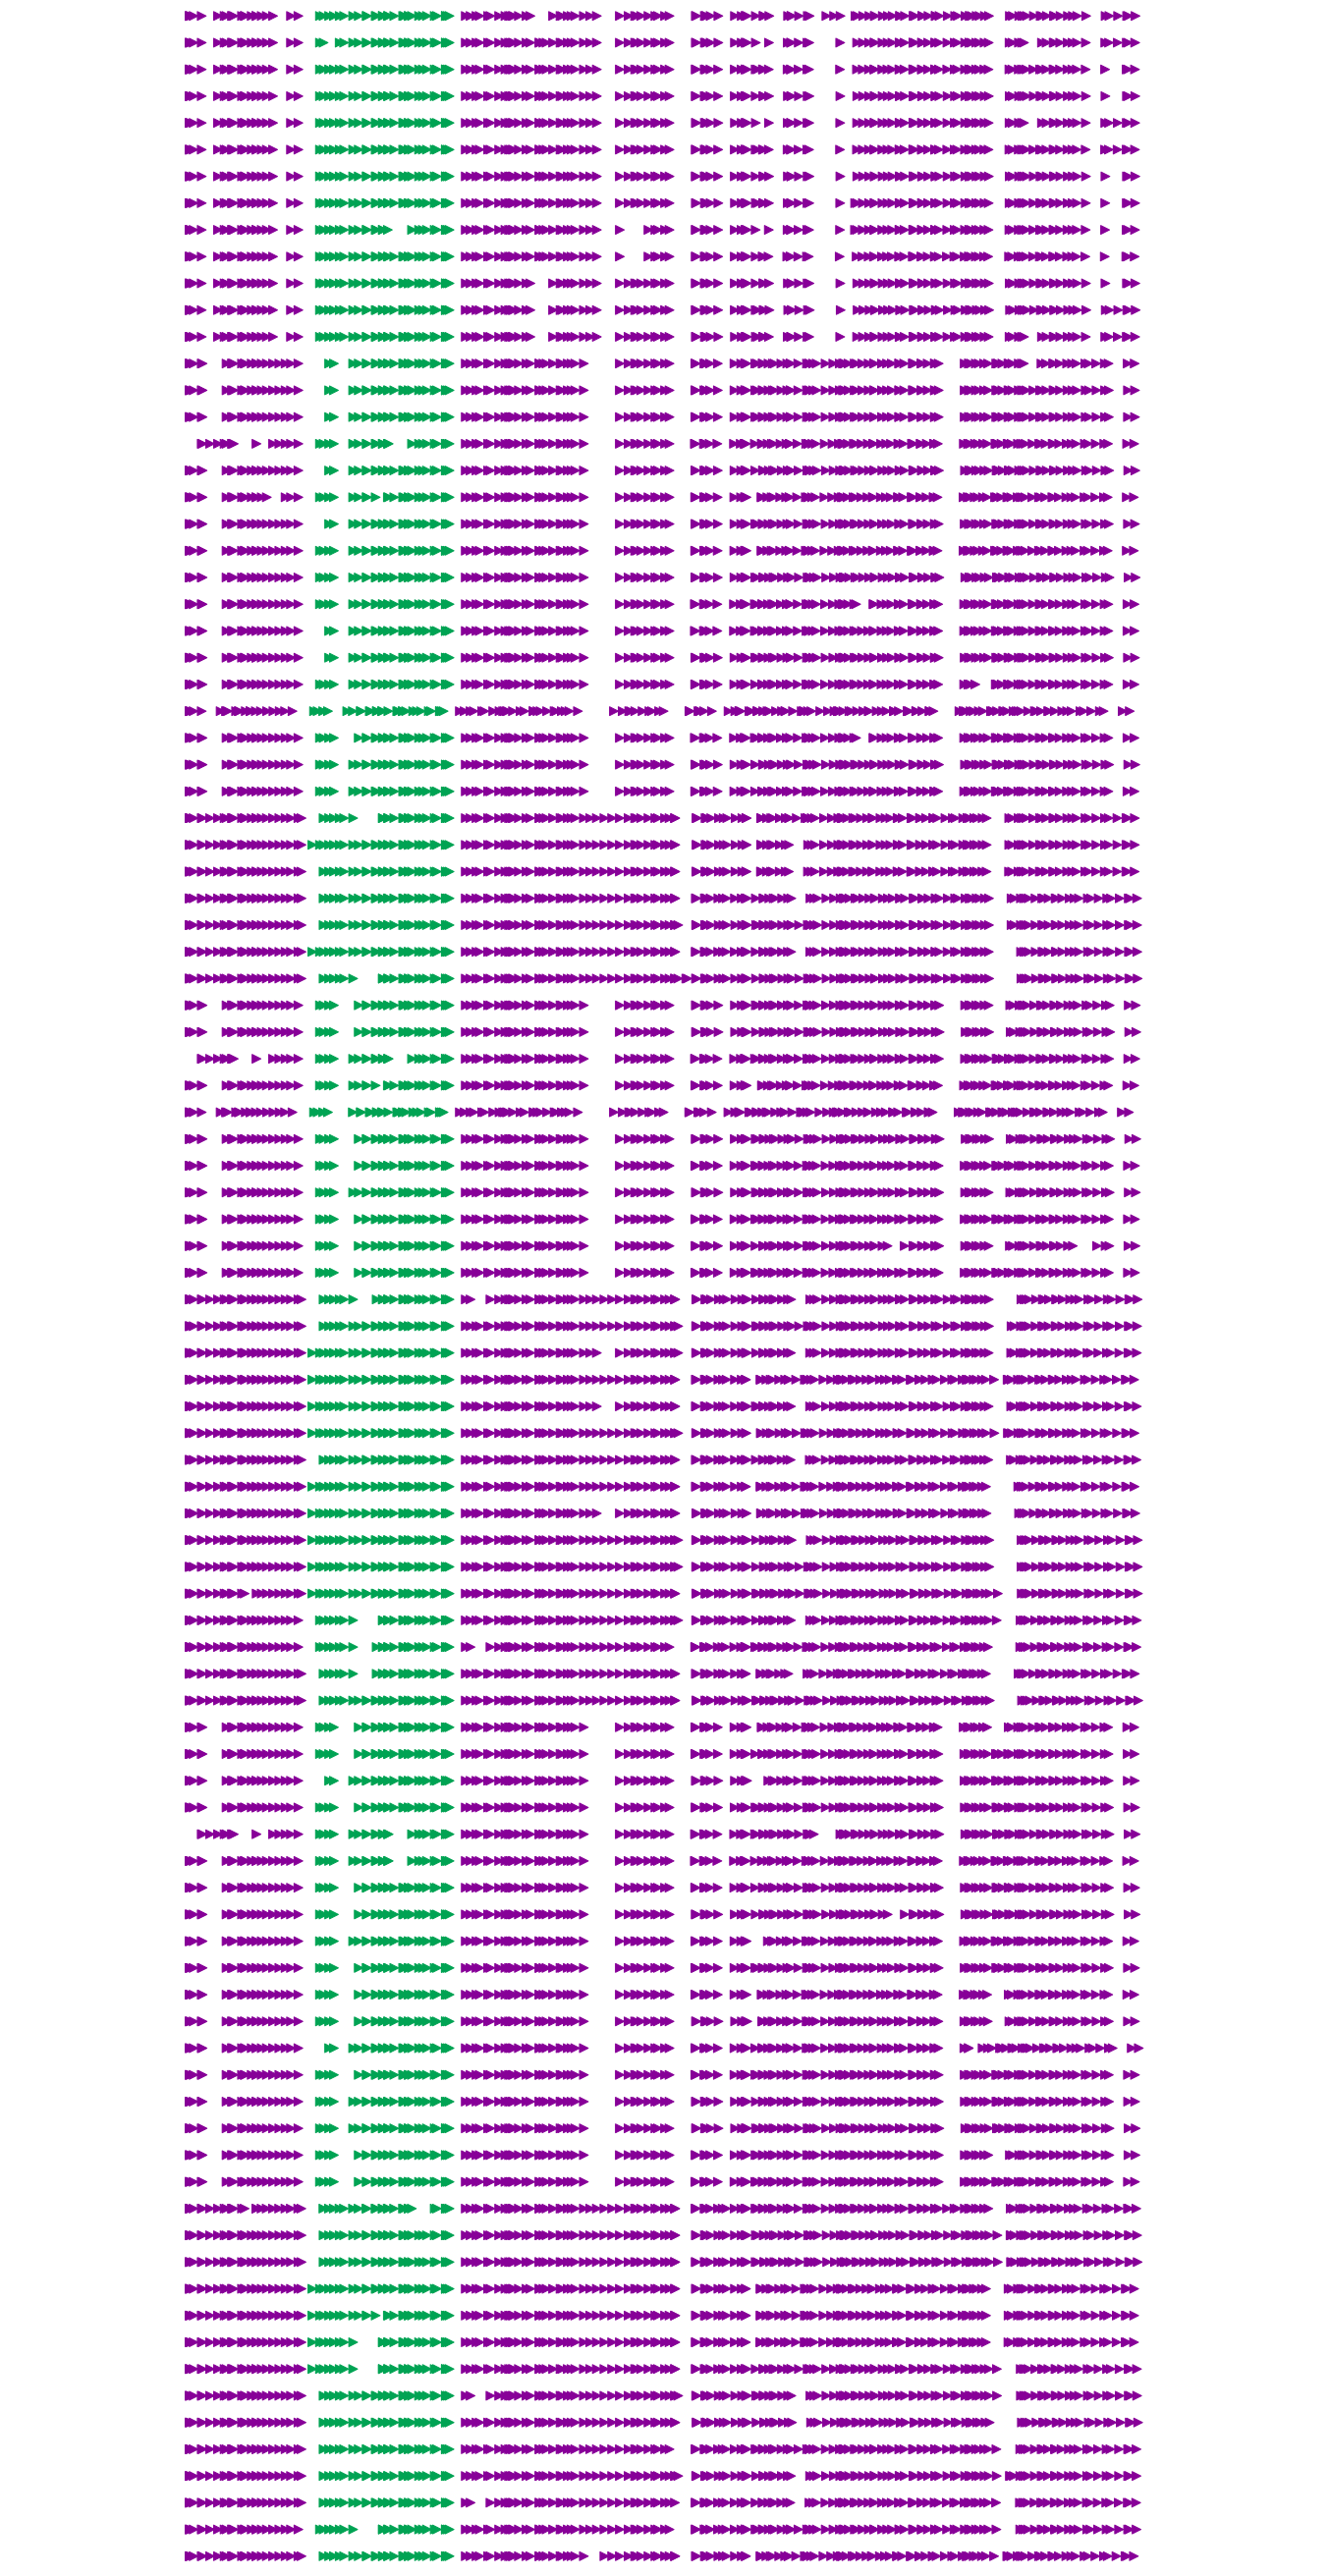

In [128]:
seq_info = repeat_db.seq_info.copy()
sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

fig = plt.figure(figsize=(24,48))
pidx = 1
for sid, data in sinfo[:96]:
    ctg, _, _ = data
    smps = repeat_sid_to_smps[sid]
    #print(seq_info[sid])
    #print(sid, len(smps))
    x, rx = [], []
    y, ry = [], []
    c, rc = [], []
    for s in smps:
        if s[1] is None:
            continue
        
        if s[0][4] == s[1][1]:
            x.append(s[0][2])
            y.append(0) # same direction
            c.append(color_theme[s[1][0]])
        else:
            rx.append(s[0][2])
            ry.append(6)
            rc.append(color_theme[s[1][0]])

            
    y = np.array(y) 
    ry = np.array(ry)
    x.reverse()
    c.reverse()
    
    plt.subplot(96, 1, pidx)
    pidx += 1
    
    #plt.figure(figsize=(24,3))
    plt.scatter(x, y, marker=">", color=c, s=80)
    plt.scatter(rx, ry, marker="<", color=rc, s=80)
    
    
    for mi in range(len(gene_matches)):
        matches = set([(_[0], _[1]) for _ in gene_matches[mi][sid]])
        track_x = [_[0] for _ in matches]
        plt.scatter(track_x, [-7-mi*2]*len(track_x), marker="s", color="black", s=2)
    
    plt.axis("off")
    plt.yticks([])
    plt.ylim(-16,12)
    plt.xlim(-1000,7000)
    #plt.text(0, -15, ctg, fontsize=24)

Assign the position of each vertex in the principal bundle

In [129]:
b_vertex_to_position = {}
i = 0
for bundle in repeat_principal_bundles:
    if len(bundle[2]) == 1: # some small segment used in both directions
        continue
    for v in bundle[2]:
        vertex = tuple(v[:2])
        if vertex in b_vertex_to_position: # some small segment used in both directions
            continue
        b_vertex_to_position[vertex] = i, bundle[0]
        i += 1
print(i)

242


construct vector of each repet unit by the projection to the bundles

In [130]:

seq_info = repeat_db.seq_info.copy()

sinfo = list(seq_info.items())
sinfo.sort(key=lambda x: x[1][0])

s_vectors = np.zeros( (len(repeat_sid_to_smps), len(b_vertex_to_position)))

ctg_labels = [""]*len(repeat_sid_to_smps)


for sid, smps in repeat_sid_to_smps.items(): 
    ctg, src, _ = seq_info[sid]
    for smp, bundle_id in smps:
        if bundle_id is None:
            continue
        node = smp[0], smp[1]
        direction = smp[4]

        if node in b_vertex_to_position:
            s_vectors[sid, b_vertex_to_position[node][0]] = 1
    ctg_labels[sid]=ctg


## filter out low count vertex

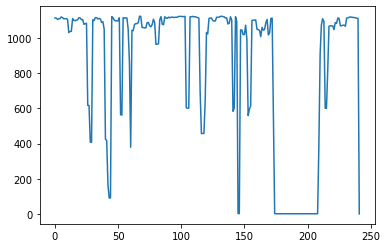

In [131]:
plt.plot(np.sum(s_vectors, axis=0))
idx = np.sum(s_vectors, axis=0) > 50
s_vectors = s_vectors[:, idx]

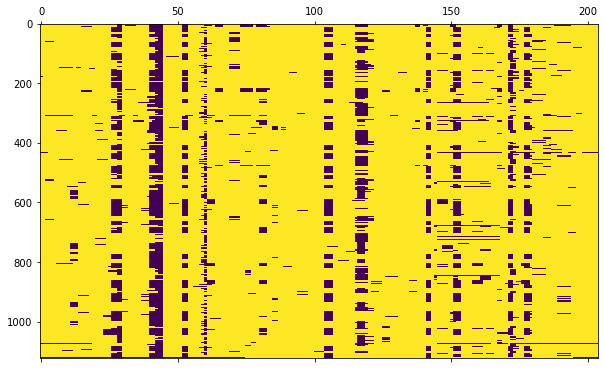

In [132]:
plt.figure(figsize=(10,6))
plt.matshow(s_vectors, fignum=1,  aspect='auto')

In [133]:
from sklearn.decomposition import PCA

In [134]:
sample2eth = {}
with open("/code/HPRC_y1_ethnic.csv") as f:
    for r in f:
        r = r.strip().split()
        sample2eth[r[0]] = r[2]

In [135]:
eths = []
for c in ctg_labels:
    #print(c, sample2eth.get(c.split("#")[0], "NA"))
    eths.append(sample2eth.get(c.split("#")[0], "NA"))

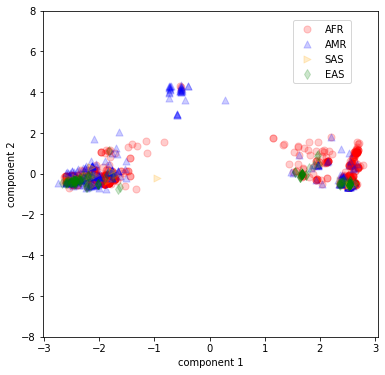

In [136]:
pca = PCA(n_components=2)
comp = pca.fit_transform(s_vectors)

[x, y] = zip( *[ (_[0], _[1]) for _ in comp ] )
c_map = {"AFR":"red", "AMR": "blue", "SAS": "orange", "EAS":"green" }
m_map = {"AFR":"o", "AMR": "^", "SAS": ">", "EAS":"d" }
colors = []

ax=plt.figure(figsize=(6,6))
for eth, color in c_map.items():
    xx = []
    yy = []
    for i in range(len(x)):
        #plt.text(x[i], y[i], eths[i])
        if eths[i] != eth:
            continue
        xx.append(x[i])
        yy.append(y[i])
    plt.scatter(xx, yy, alpha=0.2, marker=m_map[eth], c=color, s=50, label=eth)
plt.ylim(-8,8)
ax.legend(bbox_to_anchor=(0.850, 0.87), loc="upper right")

plt.xlabel("component 1")
plt.ylabel("component 2")
pca_x = x[:]
pca_y = y[:]